[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shawnrhoads/gu-psyc-347/blob/master/docs/module-04-01_Prosocial-RL-Exercises.ipynb)

# Prosocial RL Exercises

We will now fit your behavioral data to the models developed during class (as well as a few others) and then compare the models to assess which model best explains the data. This exercise is a bit different from previous exercises. I will only provide you with minimal code/text to guide you through, but you should be able to complete it all on your own using the course resources, previous tutorials/exercises, previous papers, and previous lectures!

**Once you complete this exercise, you will be well on your way to becoming a pro computational modeler!**

<hr width=50%>

Please download the data from [GitHub](https://github.com/shawnrhoads/gu-psyc-347/tree/master/docs/static/data), Canvas, or by using the following code

In [ ]:
import os, requests

# create list of URLs
urls = [f'https://raw.githubusercontent.com/shawnrhoads/gu-psyc-347/master/docs/static/data/{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,12)]

# loop through list and download data
for url in urls:
    r = requests.get(url, allow_redirects=True)
    if os.path.isdir('static/data'):
        filename = 'static/data/' + os.path.basename(url)
    else:
        filename = os.path.basename(url)
    open(filename, 'wb').write(r.content)

Import relevant modules

In [1]:
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import os                           # operating system tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
# this function will load the data into memory (assuming that
# the data are downloaded)
def load_subjects():
    '''
    input: n/a
    output: dictionary of DataFrames containing the data
    '''
        
    if os.path.isdir('static/data'):
        files = [f'static/data/{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,12)]
    else:
        files = [f'{x:02}_psyc-347-prosocial-learning.csv' for x in range(1,12)]
    
    subject_data = {}
    for index, file in enumerate(files):
        df = pd.read_csv(file, index_col='subject')
        subject_data[index] = df_filtered = df[df['outcomeDescr'] != 'practice'][['block',
                                                                                  'trial_num',
                                                                                  'true_accuracy',
                                                                                  'outcome',
                                                                                  'outcomeDescr',
                                                                                  'cumulativePts_self',
                                                                                  'cumulativePts_social']]
        
    return subject_data

In [3]:
# let's load in our data using the function above
# feel free to adjust `how_many` (the default is all 11 subjects)
subject_data = load_subjects()

## Relevant Data 

#### 4 conditions/blocks
- self, win
- self, avoid loss
- social, win
- social, avoid loss

#### Each block contains 24 trials
- 2 stimuli per trial (counterbalanced wrt side)
- outcomes associated with each stimulus is probabilistic (75%, 25%)

#### Data output key
- `block`: (play for self to win); (play for self to avoid loss); (play for next student to win); (play for next student to win)
- `trial_num`: order in which trials are displayed within a block (0-23)
- `true_accuracy`: 1 if selected stimulus with highest probability of winning or avoid losing
- `outcome`: outcome for trial (`+1`, `0`, `-1`); blank if missed
- `outcomeDescr`: text description of outcome (practice, social win, social avoid win, social loss, social avoidloss, self win, self avoid win, self loss, self avoidloss)
- `cumulativePts_self`: running total of points for self
- `cumulativePts_social`: running total of points for social

In [4]:
# view data from first subject
display(subject_data[0])

,block,trial_num,true_accuracy,outcome,outcomeDescr,cumulativePts_self,cumulativePts_social
subject,,,,,,,
1.0,social_win,0,0.0,0.0,social avoid win,1000,1000
1.0,social_win,1,1.0,1.0,social win,1000,1100
1.0,social_win,2,1.0,1.0,social win,1000,1200
1.0,social_win,3,1.0,1.0,social win,1000,1300
1.0,social_win,4,1.0,0.0,social avoid win,1000,1300
...,...,...,...,...,...,...,...
1.0,self_avoidloss,19,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,20,1.0,0.0,self avoid loss,2100,1300
1.0,self_avoidloss,21,1.0,0.0,self avoid loss,2100,1300


<hr width=50%>

In [5]:
def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
            
    return index_pos_list

## Define models

In [17]:
# Completed
def Simple_1a1t(params, choices, outcomes, block, plot=False):
    '''
    Inputs:
        - params: list of 2 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha, theta = params 
    
    if np.isnan(alpha) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    Q[int(c[t])] = Q[int(c[t])] + alpha * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            #plt.plot(range(T_temp),Q_stored[0,:])
            #plt.plot(range(T_temp),Q_stored[1,:])
            #plt.show()
            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

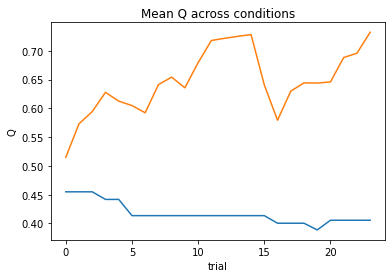

In [7]:
# example for testing function
behavior = subject_data[9]
params = [.12,2.11]
choices, outcomes, block = behavior.true_accuracy, behavior.outcome, behavior.block
subj_negll = Simple_1a1t(params, choices, outcomes, block, plot=True)

In [18]:
# Completed
def fitModel0(model=Simple_1a1t):
    
    #initialize dataframe to store results
    df = pd.DataFrame(index=range(1,12), columns=['alpha','theta','NLL'])

    # initialize list of algorithms 
    # (use one during class, but try a few others on your own)
    algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

    # loop through subjects
    for index, behavior in enumerate(subject_data.values()):
        c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
        bounds = ((0,1),(0,10))

        # gradient descent to minimize neg LL
        res_nll = np.inf # set initial neg LL to be inf

        # guess several different starting points for alpha
        for alpha_guess in np.linspace(0,1,6):
            for theta_guess in np.linspace(1,10,6):

                # guesses for alpha, theta will change on each loop
                init_guess = (alpha_guess, theta_guess)

                for algorithm in algorithms:

                    # minimize neg LL
                    result = minimize(model,
                                      init_guess,
                                      (c, o, block),
                                      bounds=bounds,
                                      method=algorithm)

                    # if current negLL is smaller than the last negLL,
                    # then store current data
                    if result.fun < res_nll and result.success:
                        res_nll = result.fun
                        param_fits = result.x

        # also, compute BIC
        BIC = len(init_guess) * np.log(len(c)) + 2*res_nll

        #store in dataframe
        df.at[index, 'alpha'] = param_fits[0]
        df.at[index, 'theta'] = param_fits[1]
        df.at[index, 'NLL'] = res_nll

        # print/plot Q values for subject   
        print(fr'subject {index+1:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
        nll = model(param_fits, c, o, block, plot=True)
    
    return df

subject 01: alpha=0.91, theta=3.13; negLL=41.24; BIC=91.60


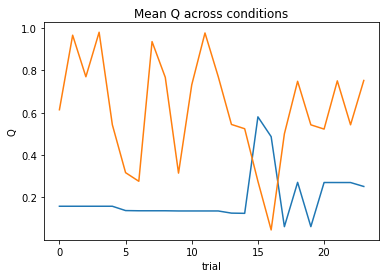

subject 02: alpha=0.04, theta=10.00; negLL=51.70; BIC=112.52


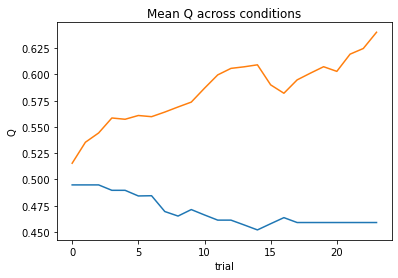

subject 03: alpha=0.08, theta=10.00; negLL=41.23; BIC=91.60


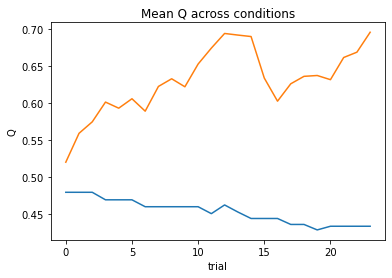

subject 04: alpha=0.00, theta=1.00; negLL=66.54; BIC=142.21


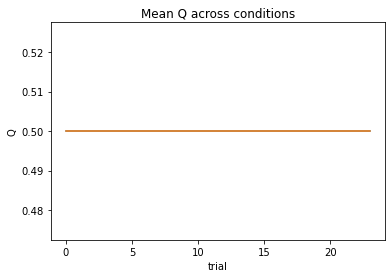

subject 05: alpha=0.23, theta=7.15; negLL=35.25; BIC=79.63


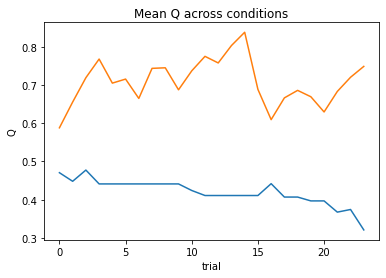

subject 06: alpha=0.44, theta=5.81; negLL=28.37; BIC=65.87


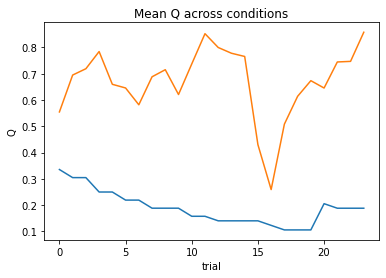

subject 07: alpha=0.15, theta=10.00; negLL=21.00; BIC=51.13


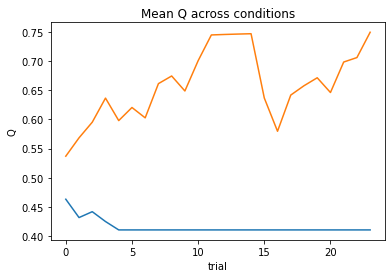

subject 08: alpha=0.16, theta=5.38; negLL=48.77; BIC=106.68


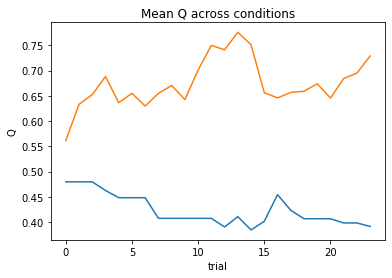

subject 09: alpha=0.31, theta=7.58; negLL=28.84; BIC=66.80


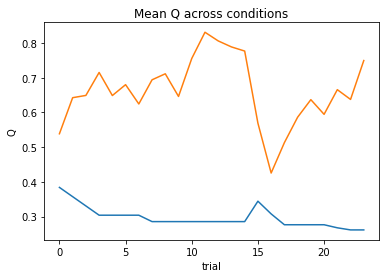

subject 10: alpha=0.33, theta=10.00; negLL=18.14; BIC=45.40


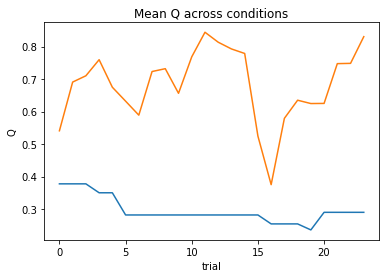

subject 11: alpha=0.27, theta=10.00; negLL=14.57; BIC=38.27


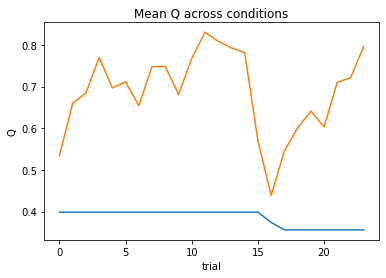

In [19]:
df0a = fitModel0(model=Simple_1a1t)

<hr width="50%">

In [20]:
# Completed
def Social_1a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self (where alpha_other = 1 - alpha_self) + 1 theta
    '''
    Inputs:
        - params: list of 2 guesses (float) for each parameter (alpha, theta)
        - choices: list of 96 choices (int) on each trial (0, 1)
        - outcomes: list of 96 outcomes (int) on each trial (-1, 0, 1)
        - block: list of 96 conditions (string) on each trial (self_win, self_avoidloss, social_win, social_avoidloss)
    Outputs:
        - negLL: negative loglikelihood computed
                 from the choice probabilities (float)
    '''
    alpha_self, theta = params 
    alpha_other = 1 - alpha_self
    
    if np.isnan(alpha_self) or np.isnan(theta): # check inputs
        return np.inf
    else:
        blocks = list(block)

        # extracts list of four strings corresponding to conditions
        unique_conditions = list(set(block))

        # init choice probs
        choiceProb = np.zeros((len(blocks)), dtype = float) 
        Q_out = {}

        count = 0
        for condition in unique_conditions:

            T_temp = blocks.count(condition)    
            Q = [0.5, 0.5] # Q at trial 0
            Q_stored = np.zeros((2, T_temp), dtype = float) 

            cur_indices = get_index_positions(blocks, condition)
            c, r = np.array(choices)[cur_indices], np.array(outcomes)[cur_indices]

            # check if self vs social
            if 'self' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r]) 
                
                
            elif 'social' in condition:
                # check if win vs avoid loss
                if 'win' in condition:
                    r = r
                elif 'avoidloss' in condition:
                    r = np.array([x+1 for x in r])
            
            # loop through trials within condition
            for t in range(T_temp):       

                if np.isnan(c[t]):
                    #don't update
                    choiceProb[count] = np.nan
                    Q_stored[:,t] = Q

                else:
                    # compute choice probabilities for k=2
                    # use the softmax rule
                    ev = np.exp(theta*np.array(Q))
                    sum_ev = np.sum(ev)
                    p = ev / sum_ev

                    # compute choice probability for actual choice
                    choiceProb[count] = p[int(c[t])]

                    # update values
                    delta = r[t] - Q[int(c[t])]
                    
                    if 'self' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_self * delta
                    elif 'other' in condition:
                        Q[int(c[t])] = Q[int(c[t])] + alpha_other * delta

                    # store Q_t+1
                    Q_stored[:,t] = Q

                count += 1

            #plt.plot(range(T_temp),Q_stored[0,:])
            #plt.plot(range(T_temp),Q_stored[1,:])
            #plt.show()
            Q_out[condition] = Q_stored
            
        negLL = -np.nansum(np.log(choiceProb))
        
        if plot: #plot mean across 4 blocks
            Q0 = np.mean(np.stack((Q_out['self_win'][0], Q_out['social_win'][0], Q_out['self_avoidloss'][0], Q_out['social_avoidloss'][0]),axis=0),axis=0)
            Q1 = np.mean(np.stack((Q_out['self_win'][1], Q_out['social_win'][1], Q_out['self_avoidloss'][1], Q_out['social_avoidloss'][1]),axis=0),axis=0)

            plt.plot(range(T_temp),Q0)
            plt.plot(range(T_temp),Q1)
            plt.title('Mean Q across conditions')
            plt.xlabel('trial')
            plt.ylabel('Q')
            plt.show()
        
        return negLL

subject 01: alpha=0.64, theta=4.72; negLL=51.62; BIC=112.38


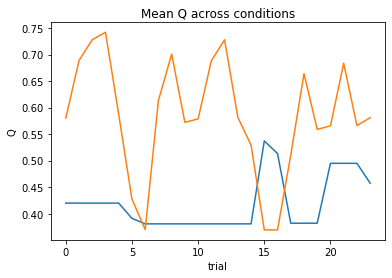

subject 02: alpha=0.10, theta=10.00; negLL=48.86; BIC=106.85


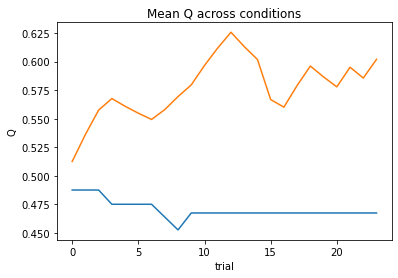

subject 03: alpha=0.12, theta=10.00; negLL=46.46; BIC=102.04


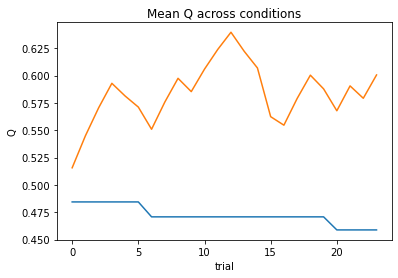

subject 04: alpha=0.00, theta=1.00; negLL=66.54; BIC=142.21


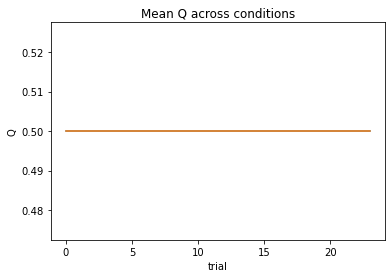

subject 05: alpha=0.26, theta=8.13; negLL=49.36; BIC=107.85


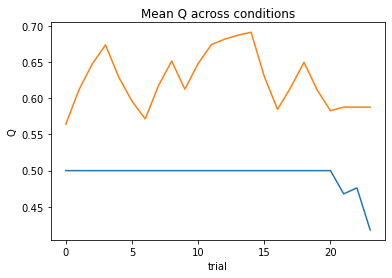

subject 06: alpha=0.31, theta=5.98; negLL=48.69; BIC=106.51


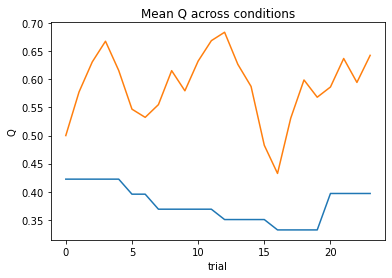

subject 07: alpha=0.15, theta=10.00; negLL=42.76; BIC=94.66


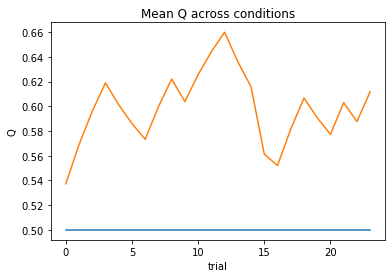

subject 08: alpha=0.05, theta=10.00; negLL=57.62; BIC=124.38


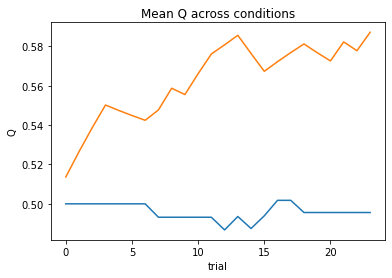

subject 09: alpha=0.47, theta=5.21; negLL=48.76; BIC=106.65


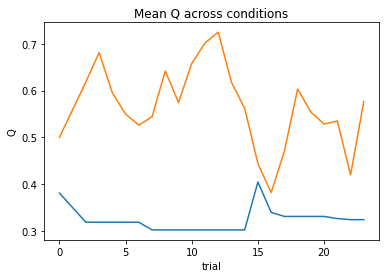

subject 10: alpha=0.31, theta=10.00; negLL=42.43; BIC=94.00


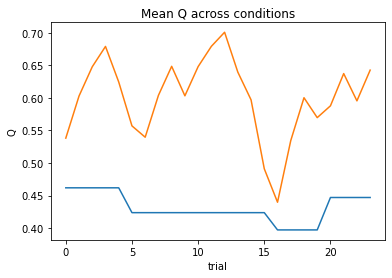

subject 11: alpha=0.35, theta=10.00; negLL=39.48; BIC=88.09


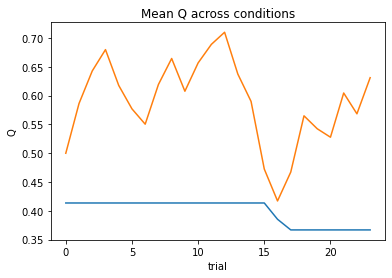

In [21]:
df0b = fitModel0(model=Social_1a1t)

<hr>

## Fitting your own models!

Each group will write code for custom models!

In [ ]:
# Model1 (6 out of 30 points)
def Social_2a1b1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self + 1 alpha_other + 1 beta + 1 theta
    
    return negLL

In [ ]:
# Completed
def fitModel1(model=Social_2a1b1t):
    
    #initialize dataframe to store results
    df = pd.DataFrame(index=range(1,12), columns=['alpha_self','alpha_other','beta','theta','NLL'])

    # initialize list of algorithms 
    # (use one during class, but try a few others on your own)
    algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

    # loop through subjects
    for index, behavior in enumerate(subject_data.values()):
        c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
        bounds = ((0,1),(0,1),(0,1),(0,10))

        # gradient descent to minimize neg LL
        res_nll = np.inf # set initial neg LL to be inf

        # guess several different starting points for alpha
        for alpha_self_guess in np.linspace(0,1,6):
            for alpha_other_guess in np.linspace(0,1,6):
                for beta_guess in np.linspace(0,1,6):
                    for theta_guess in np.linspace(1,10,12):

                        # guesses for alpha, theta will change on each loop
                        init_guess = (alpha_self_guess, 
                                      alpha_other_guess, 
                                      beta, 
                                      theta_guess)

                        for algorithm in algorithms:

                            # minimize neg LL
                            result = minimize(model,
                                              init_guess,
                                              (c, o, block),
                                              bounds=bounds,
                                              method=algorithm)

                            # if current negLL is smaller than the last negLL,
                            # then store current data
                            if result.fun < res_nll and result.success:
                                res_nll = result.fun
                                param_fits = result.x

        # also, compute BIC
        BIC = len(init_guess) * np.log(len(c)) + 2*res_nll

        #store in dataframe
        df.at[index, 'alpha_self'] = param_fits[0]
        df.at[index, 'alpha_other'] = param_fits[1]
        df.at[index, 'beta'] = param_fits[2]
        df.at[index, 'theta'] = param_fits[3]
        df.at[index, 'NLL'] = res_nll

        # print/plot Q values for subject   
        print(fr'subject {index+1:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
        nll = model(param_fits, c, o, block, plot=True)
    
    return df

In [ ]:
df1 = fitModel1(model=Social_2a1b1t)

<hr width="50%">

In [ ]:
# Model2 (6 out of 30 points)
def Valence_2a1t(params, choices, outcomes, block):
    # 1 alpha_positive + 1 alpha_negative + 1 theta
    
    return negLL

In [ ]:
def fitModel2(model=Valence_2a1t):
    
    #initialize dataframe to store results
    df = pd.DataFrame(index=range(1,12), columns=['alpha_pos','alpha_neg','theta','NLL'])

    # initialize list of algorithms 
    # (use one during class, but try a few others on your own)
    algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

    # loop through subjects
    for index, behavior in enumerate(subject_data.values()):
        c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
        bounds = ((0,1),(0,1),(0,10))

        # gradient descent to minimize neg LL
        res_nll = np.inf # set initial neg LL to be inf

        # guess several different starting points for alpha
        for alpha_pos_guess in np.linspace(0,1,12):
            for alpha_neg_guess in np.linspace(0,1,12):
                for theta_guess in np.linspace(1,10,12):

                    # guesses for alpha, theta will change on each loop
                    init_guess = (alpha_pos_guess, 
                                  alpha_neg_guess, 
                                  theta_guess)

                    for algorithm in algorithms:

                        # minimize neg LL
                        result = minimize(model,
                                          init_guess,
                                          (c, o, block),
                                          bounds=bounds,
                                          method=algorithm)

                        # if current negLL is smaller than the last negLL,
                        # then store current data
                        if result.fun < res_nll and result.success:
                            res_nll = result.fun
                            param_fits = result.x

        # also, compute BIC
        BIC = len(init_guess) * np.log(len(c)) + 2*res_nll

        #store in dataframe
        df.at[index, 'alpha_pos'] = param_fits[0]
        df.at[index, 'alpha_neg'] = param_fits[1]
        df.at[index, 'theta'] = param_fits[2]
        df.at[index, 'NLL'] = res_nll

        # print/plot Q values for subject   
        print(fr'subject {index+1:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
        nll = model(param_fits, c, o, block, plot=True)
    
    return df

In [ ]:
df2 = fitModel2(model=Valence_2a1t)

<hr width="50%">

In [ ]:
# Model3 (6 out of 30 points)
def Social_1a2b1t(params, choices, outcomes, block, plot=False):
    # 1 alpha + 1 beta_self + 1 beta_other + 1 theta
    
    return negLL

In [ ]:
# Completed
def fitModel3(model=Social_1a2b1t):
    
    #initialize dataframe to store results
    df = pd.DataFrame(index=range(1,12), columns=['alpha','beta_self','beta_other','theta','NLL'])

    # initialize list of algorithms 
    # (use one during class, but try a few others on your own)
    algorithms = ['L-BFGS-B'] #['Powell','TNC','SLSQP','trust-constr']

    # loop through subjects
    for index, behavior in enumerate(subject_data.values()):
        c, o, block = behavior.true_accuracy, behavior.outcome, behavior.block
        bounds = ((0,1),(0,1),(0,1),(0,10))

        # gradient descent to minimize neg LL
        res_nll = np.inf # set initial neg LL to be inf

        # guess several different starting points for alpha
        for alpha_guess in np.linspace(0,2,12):
            for beta_self_guess in np.linspace(0,2,12):
                for beta_other_guess in np.linspace(0,2,12):
                    for theta_guess in np.linspace(1,10,12):

                        # guesses for alpha, theta will change on each loop
                        init_guess = (alpha_guess, 
                                      beta_self_guess, 
                                      beta_other_guess, 
                                      theta_guess)

                        for algorithm in algorithms:

                            # minimize neg LL
                            result = minimize(model,
                                              init_guess,
                                              (c, o, block),
                                              bounds=bounds,
                                              method=algorithm)

                            # if current negLL is smaller than the last negLL,
                            # then store current data
                            if result.fun < res_nll and result.success:
                                res_nll = result.fun
                                param_fits = result.x

        # also, compute BIC
        BIC = len(init_guess) * np.log(len(c)) + 2*res_nll

        #store in dataframe
        df.at[index, 'alpha'] = param_fits[0]
        df.at[index, 'beta_self'] = param_fits[1]
        df.at[index, 'beta_other'] = param_fits[2]
        df.at[index, 'theta'] = param_fits[3]
        df.at[index, 'NLL'] = res_nll

        # print/plot Q values for subject   
        print(fr'subject {index+1:02}: alpha={param_fits[0]:.2f}, theta={param_fits[1]:.2f}; negLL={res_nll:.2f}; BIC={BIC:.2f}')
        nll = model(param_fits, c, o, block, plot=True)
    
    return df

In [ ]:
df3 = fitModel3(model=Social_1a2b1t)

<hr width="50%">

In [ ]:
# Bonus (not required for exercise)
def SocialValence_4a1t(params, choices, outcomes, block, plot=False):
    # 1 alpha_self_pos + 1 alpha_self_neg +
    # 1 alpha_other_pos + 1 alpha_other_neg + 1 theta
    
    return negLL

In [ ]:
# Bonus (not required for exercise)
def fitModel4(model=SocialValence_4a1t):
    
    return df

In [ ]:
# Bonus (not required for exercise)
df4 = fitModel4(model=Social_1a2b1t)

<hr width="50%">

Now, we should have run 5-6 models that we can compare to assess which model might explain the data best. Remember we store the parameter fits in Pandas DataFrames: `df0a`, `df0b`, `df1`, `df2`, `d3`, and maybe `df4` (if you completed the bonus).

Let's use this information to compute Bayesian Information Criterion ($BIC$) across subjects for each model. One way in which we can do so is by summing the negative loglikelihoods across subjects for each model and using that value to compute a $BIC$ score. Then, we can plot each $BIC$ to assess model fits. Please do this below.

***Hints***
* to compute the sum of the negative likelihoods for the first model, you would use the command: `np.nansum(df0a['NLL'].values)`.
* You can refer to [this page](https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html#model-comparison) to review Bayesian Information Criterion ($BIC$), but note that tutorial used $MSE$ to compute the $BIC$. Here, we will use the negative loglikelihood (like [in this tutorial](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html#gradient-descent)). Remember to factor in the number of free parameters in each of your models!
* Remember we will have 5-6 $BIC$ values by the end of this tutorial.

In [ ]:
# Compute BIC for each Model and Plot (2 out of 30 points)


Which of these models fit the data best? Think about whether there be others that could do better!

<hr width="50%">

In [ ]:
# Finally, please convert this cell to a Markdown cell.

# Create a Heading named "Notebook Feedback," then delete this text 
# and provide 1-2 sentences about your experience with this 
# Jupyter Notebook (e.g., Did you enjoy the exercises? Were 
# they too easy/difficult? Would you have like to see 
# anything different? Were you able to apply some skills we learned during
# class? Anything still confusing?). Finally, please rate your experience
# from (0) "did not enjoy at all" to (10) "enjoyed a great deal." Only your
# instructor will see these responses. 

Please save this file as an .html file by clicking on **'File > Download As > HTML (.html)'**

Then, save the file as **"Lastname_Exercise04.html"** and submit on Canvas.